In [2]:
import json
specs_data = json.load(open("specifications.json"))
drawings_data = json.load(open("construction_drawings.json"))

In [18]:
specs_data.keys()

dict_keys(['schema_name', 'version', 'name', 'origin', 'furniture', 'body', 'groups', 'texts', 'pictures', 'tables', 'key_value_items', 'form_items', 'pages'])

In [9]:
import re
from collections import defaultdict

spec_texts = specs_data["texts"]
csi_sections = []
current = None

for t in spec_texts:
    line = t["text"].strip()
    match = re.match(r"(\d{2} \d{2} \d{2})\s+[-\u2013]\s+(.*)", line)
    if match:
        if current:
            csi_sections.append(current)
        current = {
            "section_id": match.group(1),
            "title": match.group(2),
            "content": line
        }
    elif current:
        current["content"] += "\n" + line

if current:
    csi_sections.append(current)

print(f"✅ Parsed {len(csi_sections)} CSI sections from specs")

✅ Parsed 15 CSI sections from specs


In [14]:
print(csi_sections[0])  # Print first section for verification

{'section_id': '01 10 00', 'title': '1', 'content': '01 10 00 - 1\nPERKINS+WILL 860424 05/28/15\nFOULGER-PRATT HEADQUARTERS\nISSUE FOR PERMIT AND BID\n1.3 WORK COVERED BY CONTRACT DOCUMENTS\nThe Work of Project is defined by the Contract Documents and consists of the following:\nFit-out Level 02 of a newly constructed office building excluding work in the building core. Work to include new partitions, finishes, lighting, mechanical, electrical, fire protection, and plumbing.\nB. Type of Contract.\nProject will be constructed under a single prime contract.\n1.4 ACCESS TO SITE\nGeneral:  Contractor shall have limited use of Project site for construction operations as indicated on Drawings by the Contract limits and as indicated by requirements of this Section.\nUse of Site:  Limit use of Project site to areas within the Contract limits indicated. Do not disturb portions of Project site beyond areas in which the Work is indicated.\nLimits:  Confine construction operations to Level 02 of t

In [23]:
# ✅ Step 3: Parse Drawing Notes by Page
drawings_data['pages'].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61'])

In [26]:
from collections import defaultdict

parsed_drawings = []

for block in drawings_data["texts"]:
    text = block.get("text", "").strip()
    label = block.get("label", "")
    prov = block.get("prov", [{}])[0]
    page = prov.get("page_no", 0)
    bbox = prov.get("bbox", {})

    # Skip project titles, dates, etc.
    if label in ["section_header"] and text.upper().startswith("FOULGER"):
        continue

    # Only keep valid entries
    if len(text) < 4 or not bbox:
        continue

    parsed_drawings.append({
        "text": text,
        "label": label,
        "page": page,
        "bbox": bbox
    })


In [27]:
fire_dampers = [d for d in parsed_drawings if "fire damper" in d["text"].lower()]
for item in fire_dampers:
    print(f"[pg {item['page']}] {item['text']} @ {item['bbox']}")

[pg 3] PROVIDE FIRE DAMPERS MATCHING FIRE RATING FOR ADJACENT CONSTRUCTION THAT ARE FIRE DEPARTMENT LISTED AND APPROVED AT LOCATIONS SHOWN AND WHEREVER AIR DUCTS PENETRATE FIRE-RATED WALLS OR CEILINGS. 32. @ {'l': 688.8, 't': 838.5299882278823, 'r': 1129.587, 'b': 808.7629882278823, 'coord_origin': 'BOTTOMLEFT'}


#### Cross-Reference

In [34]:
keywords = ["fire damper", "duct", "panel", "fan", "pump"]

xref_pairs = []

for kw in keywords:
    # SPEC match
    matching_spec = next(
        (s for s in csi_sections if kw in s["content"].lower()), None
    )

    # DRAWING match
    matching_drawings = [
        d for d in parsed_drawings if kw in d["text"].lower()
    ]

    if matching_spec and matching_drawings:
        xref_pairs.append({
            "keyword": kw,
            "spec_section": matching_spec["section_id"],
            "spec_title": matching_spec["title"],
            "spec_snippet": matching_spec["content"][:250],
            "drawing_mentions": [
                {
                    "page": d["page"],
                    "text": d["text"],
                    "bbox": d["bbox"]
                }
                for d in matching_drawings
            ]
        })

In [36]:
from pprint import pprint

for x in xref_pairs:
    print(f"\n🔹 Keyword: {x['keyword']}")
    print(f"   ✅ Spec Section: {x['spec_section']} - {x['spec_title']})")
    print(f"   📄 Snippet: {x['spec_snippet'][:150]}...\n")
    for d in x["drawing_mentions"]:
        print(f"   🖼️ Drawing Page {d['page']}: {d['text']} @ {d['bbox']}")
    print("-" * 50)


🔹 Keyword: fire damper
   ✅ Spec Section: 08 83 00 - 3)
   📄 Snippet: 08 83 00 - 3
FOULGER-PRATT HEADQUARTERS
ISSUE FOR PERMIT AND BID
SECTION 09 22 16 - NON-STRUCTURAL METAL FRAMING
PART 1 - GENERAL
1.1 SUMMARY
A. Secti...

   🖼️ Drawing Page 3: PROVIDE FIRE DAMPERS MATCHING FIRE RATING FOR ADJACENT CONSTRUCTION THAT ARE FIRE DEPARTMENT LISTED AND APPROVED AT LOCATIONS SHOWN AND WHEREVER AIR DUCTS PENETRATE FIRE-RATED WALLS OR CEILINGS. 32. @ {'l': 688.8, 't': 838.5299882278823, 'r': 1129.587, 'b': 808.7629882278823, 'coord_origin': 'BOTTOMLEFT'}
--------------------------------------------------

🔹 Keyword: duct
   ✅ Spec Section: 01 10 00 - 1)
   📄 Snippet: 01 10 00 - 1
PERKINS+WILL 860424 05/28/15
FOULGER-PRATT HEADQUARTERS
ISSUE FOR PERMIT AND BID
1.3 WORK COVERED BY CONTRACT DOCUMENTS
The Work of Proje...

   🖼️ Drawing Page 3: INSTALL PIPING, DUCTS, AND OTHER SYSTEMS THAT PENETRATE FLOOR SLABS AND FIRE RATED PARTITIONS IN A MANNER THAT WILL PRESERVE THE FIRE RESISTIVE AND STRUC

##### Ok, as this is working let's build this xref on entire Specs_json and Drawings_json

In [ ]:
# for specs
spec_chunks = []

for i, t in enumerate(specs_data["texts"]):
    spec_chunks.append({
        "id": f"spec_{i}",
        "text": t["text"],
        "source": "specs"
    })

In [ ]:
# for drawings
drawing_chunks = []

for i, t in enumerate(drawings_data["texts"]):
    if len(t.get("text", "")) < 5:
        continue
    drawing_chunks.append({
        "id": f"drawing_{i}",
        "text": t["text"],
        "page": t["prov"][0]["page_no"],
        "source": "drawings",
        "bbox": t["prov"][0].get("bbox", {})
    })


#### Embed all chunks

In [42]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
spec_embeddings = model.encode([s["text"] for s in spec_chunks], show_progress_bar=True)
drawing_embeddings = model.encode([d["text"] for d in drawing_chunks], show_progress_bar=True)

/Users/pranith/Code/AI Proj/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches:   0%|          | 0/306 [00:00<?, ?it/s]/Users/pranith/Code/AI Proj/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 259/259 [00:04<00:00, 62.60it/s] 


#### Compute Cross-Reference Scores

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

sim_matrix = cosine_similarity(spec_embeddings, drawing_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Matplotlib is building the f

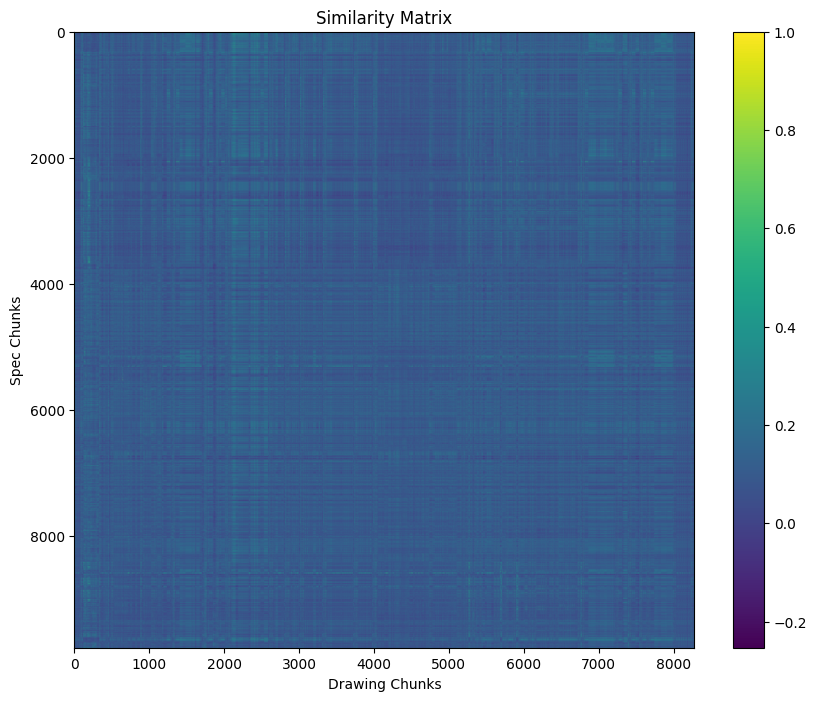

In [49]:
# Sim_matrix visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Similarity Matrix")
plt.xlabel("Drawing Chunks")
plt.ylabel("Spec Chunks")
plt.show()

Correlation Coefficient Matrix:
[[ 1.          0.56564052  0.65256187 ...  0.17100223  0.62582454
   0.50537775]
 [ 0.56564052  1.          0.82752463 ...  0.04805992  0.81385633
   0.75907999]
 [ 0.65256187  0.82752463  1.         ...  0.13785454  0.76088533
   0.76093599]
 ...
 [ 0.17100223  0.04805992  0.13785454 ...  1.          0.06235132
  -0.00152239]
 [ 0.62582454  0.81385633  0.76088533 ...  0.06235132  1.
   0.86920378]
 [ 0.50537775  0.75907999  0.76093599 ... -0.00152239  0.86920378
   1.        ]]


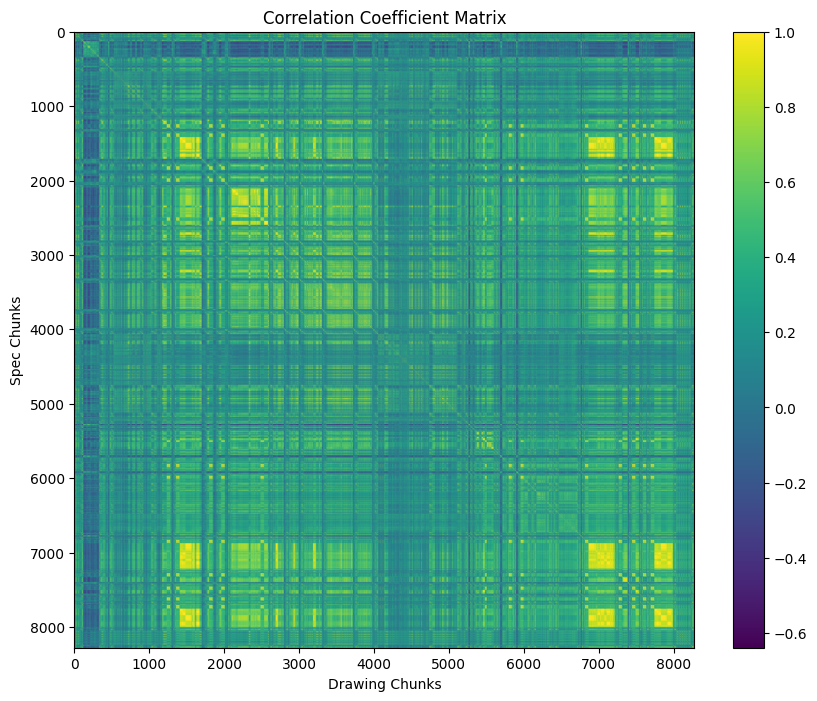

In [ ]:
# correlation coefficient matrix
correlation = np.corrcoef(sim_matrix, rowvar=False)
print("Correlation Coefficient Matrix:")
print(correlation)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(correlation, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Correlation Coefficient Matrix")
plt.xlabel("Drawing Chunks")
plt.ylabel("Spec Chunks")
plt.show()

In [44]:
xref_pairs = []

for i, spec in enumerate(spec_chunks):
    sims = list(enumerate(sim_matrix[i]))
    top_matches = sorted(sims, key=lambda x: x[1], reverse=True)[:3]

    for j, score in top_matches:
        drawing = drawing_chunks[j]
        xref_pairs.append({
            "spec_id": spec["id"],
            "spec_text": spec["text"],
            "drawing_id": drawing["id"],
            "drawing_text": drawing["text"],
            "drawing_page": drawing["page"],
            "drawing_bbox": drawing["bbox"],
            "similarity": round(float(score), 4)
        })

#### Store cross-ref data for Pinecore/RAG

In [45]:
import json

with open("xref_full.json", "w") as f:
    json.dump(xref_pairs, f, indent=2)